<center><h2>ALTeGraD 2024<br>Lab Session 1: HAN</h2><h3>Hierarchical Attention Network Using GRU</h3> 8 / 10 / 2024<br> Dr. Guokan Shang, Yang Zhang<br><br>


<b>Student name:</b> Yassine MKAOUAR


</center>
In this lab, you will get familiar with recurrent neural networks (RNNs), self-attention, and the HAN architecture <b>(Yang et al. 2016)</b> using PyTorch. In this architecture, sentence embeddings are first individually produced, and a document embedding is then computed from the sentence embeddings.<br>
<b>The deadline for this lab is October 15, 2024 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.


### = = = = =  Attention Layer = = = = =
In this section, you will fill the gaps in the code to implement the self-attention layer. This layer will be used later to define the HAN architecture. The basic idea behind attention is that rather than considering the last annotation $h_T$ as a summary of the entire sequence, which is prone to information loss, the annotations at <i>all</i> time steps are used.
The self-attention mechanism computes a weighted sum of the annotations, where the weights are determined by trainable parameters. Refer to <b>section 2.2</b> in the handout for the theoretical part, it will be needed to finish the first task.

#### <b>Task 1:</b>

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader

class AttentionWithContext(nn.Module):
    """
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """
    
    def __init__(self, input_shape, return_coefficients=False, bias=True):
        super(AttentionWithContext, self).__init__()
        self.return_coefficients = return_coefficients

        self.W = nn.Linear(input_shape, input_shape, bias=bias)
        self.tanh = nn.Tanh()
        self.u = nn.Linear(input_shape, 1, bias=False)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.W.weight.data.uniform_(-initrange, initrange)
        self.W.bias.data.uniform_(-initrange, initrange)
        self.u.weight.data.uniform_(-initrange, initrange)
    
    def generate_square_subsequent_mask(self, sz):
        # do not pass the mask to the next layers
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask
    
    def forward(self, x, mask=None):
        uit = self.W(x) # fill the gap # compute uit = W . x  where x represents ht
        uit = self.tanh(uit)
        ait = self.u(uit)
        a = torch.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            a = a*mask.double()
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        eps = 1e-9
        a = a / (torch.sum(a, axis=1, keepdim=True) + eps)
        weighted_input = torch.sum(a * x, dim=1) ### fill the gap ### # compute the attentional vector
        if self.return_coefficients:
            return  weighted_input, a ### [attentional vector, coefficients] ### use torch.sum to compute s
        else:
            return  weighted_input  ### attentional vector only ###

### = = = = = Parameters = = = = =
In this section, we define the parameters to use in our training. Such as data path, the embedding dimention <b>d</b>, the GRU layer dimensionality <b>n_units</b>, etc..<br>
The parameter <b>device</b> is used to train the model on GPU if it is available. for this purpose, if you are using Google Colab, switch your runtime to a GPU runtime to train the model with a maximum speed.<br>
<b>Bonus question:</b> What is the purpose of the parameter <i>my_patience</i>?

In [6]:
import sys
import json
import operator
import numpy as np

path_root = ''
path_to_data = path_root + 'data/'

d = 30 # dimensionality of word embeddings
n_units = 50 # RNN layer dimensionality
drop_rate = 0.5 # dropout
mfw_idx = 2 # index of the most frequent words in the dictionary 
            # 0 is for the special padding token
            # 1 is for the special out-of-vocabulary token

padding_idx = 0
oov_idx = 1
batch_size = 64
nb_epochs = 15
my_patience = 2 # for early stopping strategy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### = = = = = Data Loading = = = = =
In this section we will use first <b>wget</b> to download the data the we will load it using numpy in the first cell. While in the second cell, we will use these data to define our Pytorch data loader. Note that the data is already preprocessed, tokenized and padded.<br><br>
<b>Note: if you are running your notebook on Windows or on MacOS, <i>wget</i> will probably not work if you did not install it manually. In this case, use the provided link to download the data and change the <i>path_to_data</i> in the <i>Parameters</i> section accordingly. Otherwise, you will face no problem on Ubuntu and Google Colab.</b>

#### <b>Task 2.1:</b>

In [7]:
import urllib.request
url = "https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2199289&authkey=AHgxt3xmgG0Fu5A"
output_file = "data.zip"
urllib.request.urlretrieve(url, output_file)

!unzip data.zip

my_docs_array_train = np.load(path_to_data + 'docs_train.npy')
my_docs_array_test = np.load(path_to_data + 'docs_test.npy')

my_labels_array_train = np.load(path_to_data + 'labels_train.npy')
my_labels_array_test = np.load(path_to_data + 'labels_test.npy')

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open(path_to_data + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# invert mapping
index_to_word =  {v: k for k, v in word_to_index.items()} ### fill the gap (use a dict comprehension) ###
input_size = my_docs_array_train.shape

Archive:  data.zip
   creating: data/                 
  inflating: __MACOSX/._data         
  inflating: data/labels_train.npy   
  inflating: __MACOSX/data/._labels_train.npy  
  inflating: data/docs_test.npy      
  inflating: __MACOSX/data/._docs_test.npy  
  inflating: data/labels_test.npy    
  inflating: __MACOSX/data/._labels_test.npy  
  inflating: data/word_to_index.json  
  inflating: __MACOSX/data/._word_to_index.json  
  inflating: data/docs_train.npy     
  inflating: __MACOSX/data/._docs_train.npy  


In [16]:
import numpy
import torch
from torch.utils.data import DataLoader, Dataset


class Dataset_(Dataset):
    def __init__(self, x, y):
        self.documents = x
        self.labels = y

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        document = self.documents[index]
        label = self.labels[index] 
        sample = {
            "document": torch.tensor(document, dtype=torch.long),
            "label": torch.tensor(label,  dtype=torch.float32),
            }
        return sample


def get_loader(x, y, batch_size=32):
    dataset = Dataset_(x, y)
    data_loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            pin_memory=True,
                            drop_last=True,
                            )
    return data_loader

### = = = = = Defining Architecture = = = = =
In this section, we define the HAN architecture. We start with <i>AttentionBiGRU</i> module in order to define the sentence encoder (check Figure 3 in the handout). Then, we define the <i>TimeDistributed</i> module to allow us to forward our input (batch of document) as to the sentence encoder as <b>batch of sentences</b>, where each sentence in the document will be considered as a time step. This module also reshape the output to a batch of timesteps representations per document. Finally we define the <b>HAN</b> architecture using <i>TimeDistributed</i>, <i>AttentionWithContext</i> and <i>GRU</i>.

#### <b>Task 2.2:</b>

In [17]:

class AttentionBiGRU(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(AttentionBiGRU, self).__init__()
        self.embedding = nn.Embedding(len(index_to_word)+2,# fill the gap # vocab size
                                      d, # dimensionality of embedding space
                                      padding_idx=0)
        self.dropout = nn.Dropout(drop_rate)
        self.gru = nn.GRU(input_size=d,
                          hidden_size=n_units,
                          num_layers=1,
                          bias=True,
                          batch_first=True,
                          bidirectional=True)
        self.attention = AttentionWithContext(2 * n_units,   # fill the gap # the input shape for the attention layer
                                              return_coefficients=True)


    def forward(self, sent_ints):
        sent_wv = self.embedding(sent_ints)
        sent_wv_dr = self.dropout(sent_wv)
        sent_wa, _ = self.gru(sent_wv_dr) # fill the gap # RNN layer
        sent_att_vec, word_att_coeffs = self.attention(sent_wa) # fill the gap # attentional vector for the sent
        sent_att_vec_dr = self.dropout(sent_att_vec)
        return sent_att_vec_dr, word_att_coeffs

class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size) (448, 30)
        sent_att_vec_dr, word_att_coeffs = self.module(x_reshape)
        # We have to reshape the output
        if self.batch_first:
            sent_att_vec_dr = sent_att_vec_dr.contiguous().view(x.size(0), -1, sent_att_vec_dr.size(-1))  # (samples, timesteps, output_size)
            word_att_coeffs = word_att_coeffs.contiguous().view(x.size(0), -1, word_att_coeffs.size(-1))  # (samples, timesteps, output_size)
        else:
            sent_att_vec_dr = sent_att_vec_dr.view(-1, x.size(1), sent_att_vec_dr.size(-1))  # (timesteps, samples, output_size)
            word_att_coeffs = word_att_coeffs.view(-1, x.size(1), word_att_coeffs.size(-1))  # (timesteps, samples, output_size)
        return sent_att_vec_dr, word_att_coeffs

class HAN(nn.Module):
    def __init__(self, input_shape, n_units, index_to_word, dropout=0):
        super(HAN, self).__init__()
        self.encoder = AttentionBiGRU(input_shape, n_units, index_to_word, dropout)
        self.timeDistributed = TimeDistributed(self.encoder, True)
        self.dropout = nn.Dropout(drop_rate)
        self.gru = nn.GRU(input_size=n_units * 2,# fill the gap # the input shape of GRU layer
                          hidden_size=n_units,
                          num_layers=1,
                          bias=True,
                          batch_first=True,
                          bidirectional=True)
        self.attention = AttentionWithContext(n_units * 2, # fill the gap # the input shape of between-sentence attention layer
                                              return_coefficients=True)
        self.lin_out = nn.Linear(n_units * 2,   # fill the gap # the input size of the last linear layer
                                 1)
        self.preds = nn.Sigmoid()

    def forward(self, doc_ints):
        sent_att_vecs_dr, word_att_coeffs =  self.timeDistributed(doc_ints) # fill the gap # get sentence representation
        doc_sa, _ = self.gru(sent_att_vecs_dr)
        doc_att_vec, sent_att_coeffs = self.attention(doc_sa)
        doc_att_vec_dr = self.dropout(doc_att_vec)
        doc_att_vec_dr = self.lin_out(doc_att_vec_dr)
        return self.preds(doc_att_vec_dr), word_att_coeffs, sent_att_coeffs


### = = = = = Training = = = = =
In this section, we have two code cells. In the first one, we define our evaluation function to compute the training and validation accuracies. While in the second one, we define our model, loss and optimizer and train the model over <i>nb_epochs</i>.<br>
<b>Bonus task:</b> use <a href="https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html" target="_blank">tensorboard</a> to visualize the loss and the validation accuray during the training.

#### <b>Task 2.3:</b>

In [18]:
def evaluate_accuracy(data_loader, verbose=True):
    model.eval()
    total_loss = 0.0
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            # inference 
            output = model(data["document"].to(device))[0] 
            output = output[:, -1] # only last vector
            # total number of examples
            ntotal +=  output.shape[0]
            # number of correct predictions 
            predictions = torch.round(output)
            ncorrect += torch.sum(predictions == data["label"].to(device))  #fill me # number of correct prediction - hint: use torch.sum 
        acc = ncorrect.item() / ntotal
        if verbose:
          print("validation accuracy: {:3.2f}".format(acc*100))
        return acc

In [19]:
from tqdm import tqdm

model = HAN(input_size, n_units, index_to_word).to(device)
model = model.double()
lr = 0.001  # learning rate
criterion = torch.nn.BCELoss() # fill the gap, use Binary cross entropy from torch.nn: https://pytorch.org/docs/stable/nn.html#loss-functions
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #fill me

def train(x_train=my_docs_array_train,
          y_train=my_labels_array_train,
          x_test=my_docs_array_test,
          y_test=my_labels_array_test,
          word_dict=index_to_word,
          batch_size=batch_size):
  
    train_data = get_loader(x_train, y_train, batch_size)
    test_data = get_loader(my_docs_array_test, my_labels_array_test, batch_size)

    best_validation_acc = 0.0
    p = 0 # patience

    for epoch in range(1, nb_epochs + 1): 
        losses = []
        accuracies = []
        with tqdm(train_data, unit="batch") as tepoch:
            for idx, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                model.train()
                optimizer.zero_grad()
                input = data['document'].to(device)
                label = data['label'].to(device)
                label = label.double()
                output = model.forward(input)[0]
                output = output[:, -1]
                loss = criterion(output, label) # fill the gap # compute the loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
                optimizer.step()

                losses.append(loss.item())
                accuracy = torch.sum(torch.round(output) == label).item() / batch_size
                accuracies.append(accuracy)
                tepoch.set_postfix(loss=sum(losses)/len(losses), accuracy=100. * sum(accuracies)/len(accuracies))

        # train_acc = evaluate_accuracy(train_data, False)
        test_acc = evaluate_accuracy(test_data, False)
        print("===> Epoch {} Complete: Avg. Loss: {:.4f}, Validation Accuracy: {:3.2f}%"
              .format(epoch, sum(losses)/len(losses), 100.*test_acc))
        if test_acc >= best_validation_acc:
            best_validation_acc = test_acc
            print("Validation accuracy improved, saving model...")
            torch.save(model.state_dict(), './best_model.pt')
            p = 0
            print()
        else:
            p += 1
            if p==my_patience:
                print("Validation accuracy did not improve for {} epochs, stopping training...".format(my_patience))
    print("Loading best checkpoint...")    
    model.load_state_dict(torch.load('./best_model.pt'))
    model.eval()
    print('done.')

train()

Epoch 1: 100%|██████████| 390/390 [01:20<00:00,  4.83batch/s, accuracy=59.8, loss=0.657]


===> Epoch 1 Complete: Avg. Loss: 0.6568, Validation Accuracy: 71.07%
Validation accuracy improved, saving model...



Epoch 2: 100%|██████████| 390/390 [01:18<00:00,  4.98batch/s, accuracy=70.8, loss=0.565]


===> Epoch 2 Complete: Avg. Loss: 0.5649, Validation Accuracy: 75.20%
Validation accuracy improved, saving model...



Epoch 3: 100%|██████████| 390/390 [01:15<00:00,  5.16batch/s, accuracy=74.8, loss=0.511]


===> Epoch 3 Complete: Avg. Loss: 0.5111, Validation Accuracy: 78.99%
Validation accuracy improved, saving model...



Epoch 4: 100%|██████████| 390/390 [01:15<00:00,  5.16batch/s, accuracy=78.3, loss=0.462]


===> Epoch 4 Complete: Avg. Loss: 0.4617, Validation Accuracy: 80.04%
Validation accuracy improved, saving model...



Epoch 5: 100%|██████████| 390/390 [01:15<00:00,  5.17batch/s, accuracy=80.2, loss=0.429]


===> Epoch 5 Complete: Avg. Loss: 0.4290, Validation Accuracy: 82.02%
Validation accuracy improved, saving model...



Epoch 6: 100%|██████████| 390/390 [01:19<00:00,  4.89batch/s, accuracy=81.6, loss=0.407]


===> Epoch 6 Complete: Avg. Loss: 0.4067, Validation Accuracy: 82.79%
Validation accuracy improved, saving model...



Epoch 7: 100%|██████████| 390/390 [01:18<00:00,  4.98batch/s, accuracy=83, loss=0.383]  


===> Epoch 7 Complete: Avg. Loss: 0.3832, Validation Accuracy: 82.02%


Epoch 8: 100%|██████████| 390/390 [01:18<00:00,  4.97batch/s, accuracy=84.3, loss=0.359]


===> Epoch 8 Complete: Avg. Loss: 0.3595, Validation Accuracy: 83.48%
Validation accuracy improved, saving model...



Epoch 9: 100%|██████████| 390/390 [01:17<00:00,  5.04batch/s, accuracy=85, loss=0.346]  


===> Epoch 9 Complete: Avg. Loss: 0.3463, Validation Accuracy: 84.32%
Validation accuracy improved, saving model...



Epoch 10: 100%|██████████| 390/390 [01:21<00:00,  4.76batch/s, accuracy=85.5, loss=0.333]


===> Epoch 10 Complete: Avg. Loss: 0.3328, Validation Accuracy: 84.33%
Validation accuracy improved, saving model...



Epoch 11: 100%|██████████| 390/390 [01:20<00:00,  4.83batch/s, accuracy=86.7, loss=0.313]


===> Epoch 11 Complete: Avg. Loss: 0.3125, Validation Accuracy: 83.69%


Epoch 12: 100%|██████████| 390/390 [01:20<00:00,  4.87batch/s, accuracy=87, loss=0.304]  


===> Epoch 12 Complete: Avg. Loss: 0.3043, Validation Accuracy: 84.80%
Validation accuracy improved, saving model...



Epoch 13: 100%|██████████| 390/390 [01:18<00:00,  4.97batch/s, accuracy=87.6, loss=0.294]


===> Epoch 13 Complete: Avg. Loss: 0.2935, Validation Accuracy: 84.76%


Epoch 14: 100%|██████████| 390/390 [01:20<00:00,  4.86batch/s, accuracy=88, loss=0.286]  


===> Epoch 14 Complete: Avg. Loss: 0.2862, Validation Accuracy: 84.65%
Validation accuracy did not improve for 2 epochs, stopping training...


Epoch 15: 100%|██████████| 390/390 [01:22<00:00,  4.70batch/s, accuracy=88.7, loss=0.274]


===> Epoch 15 Complete: Avg. Loss: 0.2745, Validation Accuracy: 83.61%
Loading best checkpoint...
done.


### = = = = = Extraction of Attention Coefficients = = = = =
In this section, we will extract and display the attention coefficients on two levels: sentence level and word level. To do so, we will extract the corresponding weights from our model.
#### <b>Task 3:</b>

In [48]:
# select last review:
my_review = my_docs_array_test[-1:,:,:]
 
# convert integer review to text:
index_to_word[1] = 'OOV'
my_review_text = [[index_to_word[idx] for idx in sent if idx in index_to_word] for sent in my_review.tolist()[0]]

###   &emsp;&emsp;  = = = = = Attention Over Sentences in the Document = = = = =

In [49]:
# Convert the review to a torch tensor and pass it through the model
my_review_tensor = torch.tensor(my_review, dtype=torch.long).to(device)

with torch.no_grad():
    _, _, sent_coeffs = model(my_review_tensor) # fill the gap # get sentence attention coeffs by passing the review to the model - (you need to convert the inout torch tensor)
sent_coeffs = sent_coeffs[0,:,:]

for elt in zip(sent_coeffs[:,0].tolist(),[' '.join(elt) for elt in my_review_text]):
    print(round(elt[0]*100,2),elt[1])

11.74 There 's a sign on The Lost Highway that says : OOV SPOILERS OOV ( but you already knew that , did n't you ? )
11.04 Since there 's a great deal of people that apparently did not get the point of this movie , I 'd like to contribute my interpretation of why the plot
10.97 As others have pointed out , one single viewing of this movie is not sufficient .
13.86 If you have the DVD of MD , you can OOV ' by looking at David Lynch 's 'Top 10 OOV to OOV MD ' ( but only upon second
14.99 ; ) First of all , Mulholland Drive is downright brilliant .
18.89 A masterpiece .
18.5 This is the kind of movie that refuse to leave your head .


### &emsp;&emsp; = = = = = Attention Over Words in Each Sentence = = = = =

In [50]:
_, word_coeffs, _ = model(my_review_tensor) # fill the gap # get words attention coeffs by passing the review to the model - (you need to convert the inout torch tensor)

word_coeffs_list = word_coeffs.reshape(7,30).tolist()

# match text and coefficients:
text_word_coeffs = [list(zip(words,word_coeffs_list[idx][:len(words)])) for idx,words in enumerate(my_review_text)]

for sent in text_word_coeffs:
    [print(elt) for elt in sent]
    print('= = = =')

# sort words by importance within each sentence:
text_word_coeffs_sorted = [sorted(elt,key=operator.itemgetter(1),reverse=True) for elt in text_word_coeffs]

for sent in text_word_coeffs_sorted:
    [print(elt) for elt in sent]
    print('= = = =')

('There', 0.04639659355350277)
("'s", 0.026379010509545605)
('a', 0.024483692021626823)
('sign', 0.0569164054513823)
('on', 0.034179010205441354)
('The', 0.037298886822673814)
('Lost', 0.061837694078922305)
('Highway', 0.07579129302607625)
('that', 0.023099268404780306)
('says', 0.03542226496390039)
(':', 0.04238595890791367)
('OOV', 0.022269196950804235)
('SPOILERS', 0.022332298805883707)
('OOV', 0.01957562531381369)
('(', 0.017571025785610286)
('but', 0.03020927494235406)
('you', 0.057911582338237184)
('already', 0.05691951112531536)
('knew', 0.04068181220478346)
('that', 0.0214735821548947)
(',', 0.020421295540045296)
('did', 0.019430402638362147)
("n't", 0.022123093944858743)
('you', 0.040513446017215994)
('?', 0.02272751114308613)
(')', 0.022692958163960813)
= = = =
('Since', 0.052564913431073924)
('there', 0.031086634379880698)
("'s", 0.027865577344791545)
('a', 0.03054205624728576)
('great', 0.10842920644762079)
('deal', 0.043757365885625094)
('of', 0.022523387407750273)
('peopl

# Plot attention coefficients for another document

In [55]:
import matplotlib.pyplot as plt

# Select the last review/document from the test set (as an example)
my_review = my_docs_array_test[-15:,:,:]

# Convert integer review to text:
index_to_word[1] = 'OOV'  # Handle out-of-vocabulary words
my_review_text = [[index_to_word[idx] for idx in sent if idx in index_to_word] for sent in my_review.tolist()[0]]

# Convert the review to a tensor and move it to the device (GPU/CPU)
my_review_tensor = torch.tensor(my_review, dtype=torch.long).to(device)

# Get the sentence attention coefficients by passing the review through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    _, word_att_coeffs, sent_att_coeffs = model(my_review_tensor)

# No need to convert to NumPy, we can keep using PyTorch tensors
sent_att_coeffs = sent_att_coeffs[0]  # Shape: (num_sentences, 1)
word_att_coeffs = word_att_coeffs[0]  # Shape: (num_sentences, num_words, 1)

# Convert the attention coefficients to lists directly using .tolist()
sent_att_coeffs = sent_att_coeffs.squeeze().tolist()  # Shape: (num_sentences,)
word_att_coeffs = word_att_coeffs.squeeze().tolist()  # Shape: (num_sentences, num_words)

# Print sentence-level attention scores
for sent_coeff, sentence in zip(sent_att_coeffs, [' '.join(sent) for sent in my_review_text]):
    print(f"Sentence attention: {round(sent_coeff * 100, 2)}% -> {sentence}")

Sentence attention: 20.76% -> Oh , where the hell should I begin ?
Sentence attention: 12.67% -> Give a brief summary of the story ?
Sentence attention: 11.76% -> No .
Sentence attention: 9.23% -> either you 've already heard it , or do n't want to .
Sentence attention: 21.68% -> Either way , it sucks .
Sentence attention: 12.12% -> Much like the movie .
Sentence attention: 11.77% -> I happen to be a OOV horror movie aficionado , and I must say this is one of the dumbest and most OOV movies I 've ever had the displeasure


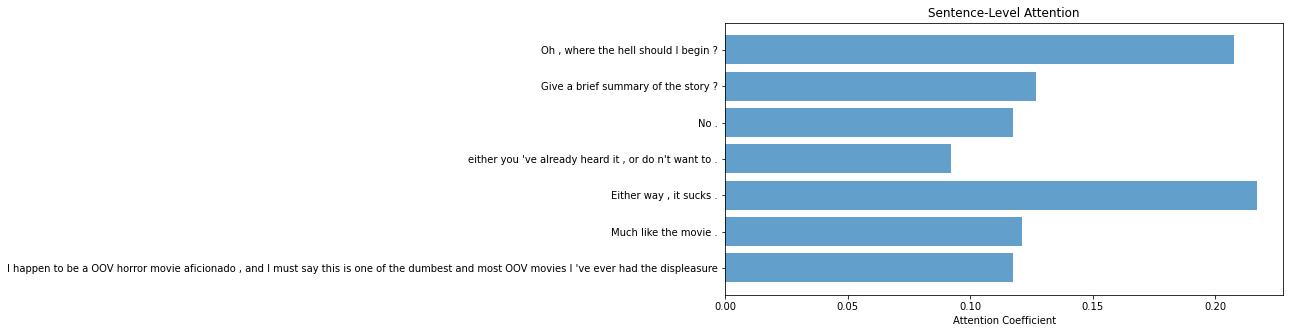

In [56]:
# Plot the sentence-level attention coefficients using Python lists
def plot_sentence_attention(sent_coeffs, sentences):
    plt.figure(figsize=(10, 5))
    
    # Convert PyTorch tensors to lists
    y_pos = list(range(len(sentences)))  # Use standard Python range for y-axis
    sent_coeffs_list = sent_coeffs.tolist()  # Convert attention coefficients to list
    
    # Use lists directly in plt.barh
    plt.barh(y_pos, sent_coeffs_list, align='center', alpha=0.7)
    
    # Set the labels for the y-axis using the sentences
    plt.yticks(y_pos, sentences, fontsize=10)
    plt.xlabel('Attention Coefficient')
    plt.title('Sentence-Level Attention')
    
    # Reverse the order to show the first sentence at the top
    plt.gca().invert_yaxis()
    plt.show()

# Prepare the sentence attention and sentence text
sentences = [' '.join(sent) for sent in my_review_text]

# Plot sentence-level attention (convert tensors to lists)
plot_sentence_attention(torch.tensor(sent_att_coeffs), sentences)